In [1]:
%run "setup.py"
if os.path.isfile('database_credentials.py'):
    %run "database_credentials.py"

In [2]:
import psycopg2
con = psycopg2.connect(database=os.environ['VN_ORMA_DB_DB'], user=os.environ['VN_ORMA_DB_USER'], password=os.environ['VN_ORMA_DB_PASS'], host=os.environ['VN_ORMA_DB_HOST'])

In [3]:
def bytea2bytes(value, cur):
    m = psycopg2.BINARY(value, cur)
    if m is not None:
        return m.tobytes()

BYTEA2BYTES = psycopg2.extensions.new_type(psycopg2.BINARY.values, 'BYTEA2BYTES', bytea2bytes)
psycopg2.extensions.register_type(BYTEA2BYTES)

## Region IDs

In [4]:
sql = 'select id, "type", name_en, name_vn from admin_boundaries'
admin_names = pd.read_sql(sql, con)
admin_names.set_index(['id'], inplace=True)

districts = admin_names[admin_names.type=='district'][['name_vn']]
districts.columns=['district']

provinces = admin_names[admin_names.type=='province'][['name_vn']]
provinces.columns=['province']



# REF DATA

In [5]:
province_name = "Hà Giang"
province_id = provinces.query('province == @province_name').index[0]
province_id

294

In [6]:
%%time
sql = f'SELECT way_id, st_asBinary(geom) AS geom, district, province, "length" as length_from_db from lines_with_admin where length>0 AND province = {province_id}'
ways_by_region = pd.read_sql(sql, con)

CPU times: user 33.8 ms, sys: 34 ms, total: 67.8 ms
Wall time: 3.98 s


In [7]:
ways_by_region.shape

(1884, 5)

In [8]:
%%time
ways_by_region.geom = ways_by_region.geom.apply(shapely.wkb.loads)
ways_by_region.columns = ['way_id','geom', 'district_id', 'province_id', "length_from_db"]

CPU times: user 44.1 ms, sys: 3.97 ms, total: 48.1 ms
Wall time: 102 ms


In [9]:
%%time
ways_by_region = ways_by_region.assign(way_id_district='')
ways_by_region['way_id_district']=ways_by_region['way_id'].astype(str)+'_'+ways_by_region['district_id'].astype(str)
# ways_by_region = ways_by_region[ways_by_region['length']>0.025] #Lets only get stretches longer than 25 meters
ways_by_region.head()

CPU times: user 7.56 ms, sys: 1.32 ms, total: 8.88 ms
Wall time: 11.1 ms


,way_id,geom,district_id,province_id,length_from_db,way_id_district
0,636849,"LINESTRING (105.0159318 22.8441537, 105.016066...",295,294,1.257061,636849_295
1,636850,"LINESTRING (105.0170819 22.847096, 105.016905 ...",295,294,0.400964,636850_295
2,636851,"LINESTRING (105.0173254 22.8478546, 105.017208...",295,294,0.164269,636851_295
3,636852,"LINESTRING (105.0173467 22.8467741, 105.017471...",295,294,0.282407,636852_295
4,636853,"LINESTRING (105.0162879 22.8484085, 105.016218...",295,294,0.300861,636853_295


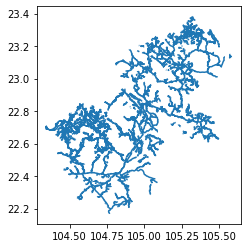

In [14]:
gdf = gpd.GeoDataFrame(ways_by_region, geometry='geom', crs=4326)
gdf.plot()
plt.show()

gdf.to_file('../data/ha_giang/from_orma.gpkg', driver='GPKG')

In [12]:
os.getcwd()

'/Users/jamescook/world_bank/roads-cba-py/notebooks'

In [62]:
gdf_projected = gdf.to_crs(32648)

(array([  2.,   7.,  34.,  62.,  95., 118., 177., 300., 286., 803.]),
 array([1.00034688, 1.00035237, 1.00035786, 1.00036335, 1.00036884,
        1.00037433, 1.00037982, 1.00038531, 1.0003908 , 1.00039629,
        1.00040178]),
 <BarContainer object of 10 artists>)

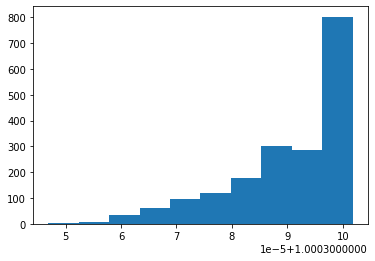

In [65]:
import geopandas as gpd
import shapely
from functools import partial
import pyproj


def calc_length(row):        
    shapely_geom = shapely.geometry.shape(row.geom)
    return round(shapely_geom.length,4)

gdf_projected['LengthJamie'] = gdf_projected.apply(calc_length,axis=1) / 1000

plt.hist(gdf_projected['length_from_db']/ gdf_projected['LengthJamie'])


## current way tags

In [15]:
%%time
sql = "select * from current_way_tags"
way_tags_raw = pd.read_sql(sql, con)

CPU times: user 291 ms, sys: 120 ms, total: 411 ms
Wall time: 5.39 s


In [16]:
way_tags = way_tags_raw.pivot(index='way_id', columns='k', values='v').reset_index()
way_tags.drop(['province', 'addr:district', 'addr:province'], axis=1, inplace=True)

In [27]:
way_vpromms = way_tags[['way_id', 'or_vpromms']]
way_vpromms = way_vpromms[~way_vpromms['or_vpromms'].isna()]
way_vpromms.head()

k,way_id,or_vpromms
28672,446981,213NS00012
28673,446982,213NS00012
28674,446983,213NS00012
28675,446984,213NS00012
28676,446985,213NS00012


In [31]:
vp_id = '032HG00006'
way_vpromms.query('or_vpromms == @vp_id')

k,way_id,or_vpromms
217686,636000,032HG00006
217687,636001,032HG00006


## Road properties

In [18]:
sql = "select * from road_properties where properties != '{}'"
road_properties_raw = pd.read_sql(sql, con)
road_properties_raw.head()

,id,properties,status
0,674XT00085,"{'length': 0.904841328925019, 'Road Name': 'Đư...",reviewed
1,233DT00034,"{'iri_max': 20.42, 'iri_med': 15.07, 'iri_min'...",pending
2,034YM00181,"{'length': 2.0, 'Road Name': 'Đường đến thôn N...",pending
3,313HN00013,"{'length': 10.8422197634643, 'Road Name': 'Bồn...",pending
4,034YM00216,"{'length': 1.1, 'Road Name': 'Đường đi nhóm hộ...",pending


In [21]:
road_properties = json_normalize(road_properties_raw['properties'].to_list())
all_cols = list(road_properties.columns)

new_headers = {}
inversed_headers = {}
for col in all_cols:
    normalized = col.strip().lower()
    if normalized in inversed_headers.keys():
        fltr = ~road_properties[col].isna()
        road_properties.loc[fltr, inversed_headers[normalized]] = road_properties.loc[fltr, col]
        continue
    inversed_headers[normalized] = col
    new_headers[col] = normalized
road_properties = road_properties[list(new_headers.keys())]
road_properties.columns = [new_headers[x] for x in road_properties.columns]

road_properties = road_properties.assign(iri=road_properties.iri_med)
road_properties.loc[road_properties.iri.isna(),'iri'] = road_properties.loc[road_properties.iri.isna(),'iri_mean']
road_properties.loc[road_properties.iri.isna(),'iri'] = road_properties.loc[road_properties.iri.isna(),'iri_max']
road_properties.loc[road_properties.iri.isna(),'iri'] = road_properties.loc[road_properties.iri.isna(),'iri_min']
columns_of_interest = ['length','road name', 'management', 'road end location', 'road start location', 'road number', 'iri', 'road width']
road_properties = road_properties[columns_of_interest]
road_properties = road_properties_raw[['id']].join(road_properties)
road_properties.drop(['length'], axis=1, inplace=True)

In [24]:
road_properties.head()

,id,road name,management,road end location,road start location,road number,iri,road width
0,674XT00085,Đường xã Xuân Kiên,4,Xóm 12B (giáp Xuân Tiến),Cầu đường 489C (xóm 14),NaN,NaN,NaN
1,233DT00034,NaN,NaN,NaN,NaN,NaN,15.07,NaN
2,034YM00181,Đường đến thôn Nà Mòn,NaN,NaN,NaN,ĐX.164,NaN,NaN
3,313HN00013,Bồng Sơn - Hoài Hương,3,Hoài Hương,Bồng Sơn,,NaN,NaN
4,034YM00216,Đường đi nhóm hộ thôn Phiêng Kiền,NaN,NaN,NaN,ĐX.199,NaN,NaN


## Old data

In [74]:
ronet_data = pd.read_csv('../data/Traffic_mockup.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/Traffic_mockup.csv'

In [75]:
ronet_data.head()

NameError: name 'ronet_data' is not defined

# Data fusion

In [78]:
def x0(geo):
    if geo.geometryType() != 'LineString':
        return np.nan
    return geo.xy[0][0]
def x1(geo):
    if geo.geometryType() != 'LineString':
        return np.nan
    return geo.xy[0][-1]
def y0(geo):
    if geo.geometryType() != 'LineString':
        return np.nan
    return geo.xy[1][0]
def y1(geo):
    if geo.geometryType() != 'LineString':
        return np.nan
    return geo.xy[1][-1]

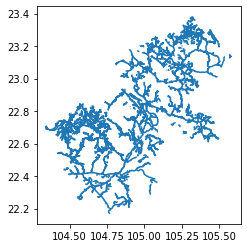

CPU times: user 2.41 s, sys: 168 ms, total: 2.57 s
Wall time: 2.8 s


In [127]:
%%time
merged_data = gdf.merge(districts, how='left',left_on='district_id', right_on='id')
merged_data = merged_data.merge(provinces, how='left',left_on='province_id', right_on='id')
merged_data.drop(['district_id', 'province_id'], axis=1, inplace=True)
merged_data = merged_data.merge(way_tags, on='way_id', how='left')
merged_data = merged_data.merge(road_properties, how='left', left_on='or_vpromms', right_on='id')
merged_data = merged_data.assign(empty= '', aadt=0, x_0= merged_data.geom.apply(x0), x_1= merged_data.geom.apply(x1), y_0= merged_data.geom.apply(y0), y_1= merged_data.geom.apply(y1))
merged_data.columns = [x[3:] if x[:3]=='or_' else x for x in merged_data.columns]


In [73]:
%%time
merged_data = merged_data.merge(ronet_data, left_on='vpromms', right_on='VPROMMS_ID', how='left')

# For now let's just make it easy and get the first element that got matched with our IDs
merged_data.drop_duplicates(['way_id_district'], inplace=True)

NameError: name 'ronet_data' is not defined

In [42]:
labeled_data = merged_data

In [76]:
np.sum(labeled_data[~labeled_data.vpromms.isna()]['length']), np.sum(labeled_data['length'])

NameError: name 'labeled_data' is not defined

### Merges data on equivalent fields

In [77]:
field_pairs = [['name', 'road name'], ['width', 'section_carraigeway'], ['width', 'road width'], ['condition', 'section_pavement_condition'], ['width', 'OLD_WIDTH'], ['section_traffic', 'OLD_traffic_level'], ['link_class', 'OLD_CLASS'], ['section_surface', 'OLD_SURFACE'], ['condition', 'OLD_CONDITION']]

for fld, alt_fld in field_pairs:
    merged_data.loc[merged_data[fld].isna(), fld] = merged_data.loc[merged_data[fld].isna(), alt_fld]

KeyError: 'OLD_WIDTH'

### Fixes data types

In [128]:
labeled_data.loc[:, ' '] = labeled_data.section_carraigeway.str.replace(",", ".").astype(float)
labeled_data.loc[~labeled_data['section_pavement'].isna(), 'section_pavement'] = labeled_data.loc[~labeled_data['section_pavement'].isna(), 'section_pavement'].str[-1]
# labeled_data.loc[~labeled_data['section_surface'].isna(), 'section_surface'] = labeled_data.loc[~labeled_data['section_surface'].isna(), 'section_surface'].str[0]
labeled_data.loc[~labeled_data['section_pavement_condition'].isna(), 'section_pavement_condition'] = labeled_data.loc[~labeled_data['section_pavement_condition'].isna(), 'section_pavement_condition'].str[0]

traffic_fields = ['section_motorcycle', 'section_small_car', 'section_medium_car', 'section_delivery_vehicle', 'section_light_truck', 
                  'section_medium_truck', 'section_heavy_truck', 'section_articulated_truck', 'section_small_bus', 'section_medium_bus', 'section_large_bus']
    
tot = np.zeros(labeled_data.shape[0])
for field in traffic_fields:
    labeled_data[field].fillna(0, inplace=True)
    labeled_data.loc[~labeled_data[field].apply(lambda x: str(x).isnumeric()), field] = 0 
    labeled_data.loc[:, field] = labeled_data[field].astype(float)
    tot += labeled_data[field].values
labeled_data.loc[:, 'aadt'] = tot


for x in [1, 2, 3]:
    labeled_data.loc[labeled_data['surface'] == x, 'surface'] = '1'
    
for x in [4, 5]:
    labeled_data.loc[labeled_data['surface'] == x, 'surface'] = '2'
    
for x in ['concrete', 'asphalt', 'paved', 'concrete:lanes', 'Concrete']:
    labeled_data.loc[labeled_data['surface'] == x, 'surface'] = '1'

for x in ['ground', 'unpaved', 'earth']:
    labeled_data.loc[labeled_data['surface'] == x, 'surface'] = '2'

for x in ['concrete', 'concrete:lanes', 'Concrete']:
    labeled_data.loc[(labeled_data['surface'] == x) & (labeled_data.section_surface.isna()), 'section_surface'] = '1'
    
for x in ['asphalt']:
    labeled_data.loc[(labeled_data['surface'] == x) & (labeled_data.section_surface.isna()), 'section_surface'] = '2'
    
for x in ['earth']:
    labeled_data.loc[(labeled_data['surface'] == x) & (labeled_data.section_surface.isna()), 'section_surface'] = '5'
    
    
for i, cl in enumerate(['Class I','Class II','Class III','Class IV','Class V','Class VI','A','B','C','D']):
    labeled_data.loc[labeled_data['link_class'].str.lower() == cl.lower(), 'link_class'] = i + 1
    
for i, cl in enumerate(['Very Good', 'Good', 'Fair', 'Poor', 'Very Poor']):
    labeled_data.loc[labeled_data['condition'].str.lower() == cl.lower(), 'condition'] = i + 1
labeled_data.loc[labeled_data['condition'].str.lower() =='bad', 'condition'] = 4

NameError: name 'labeled_data' is not defined

### Creates outputs

In [46]:
ha_giang = labeled_data[labeled_data.province=='Hà Giang']
filtered = ha_giang[(~ha_giang.section_lanes.isna())|(~ha_giang.width.isna())]

filtered = filtered[~filtered.link_class.isna()]
# filtered = filtered[~filtered.section_temperature.isna()]
# filtered = filtered[~filtered.section_moisture.isna()]
# filtered = filtered[~filtered.section_traffic_growth.isna()]

# filtered = filtered[~filtered.section_terrain.isna()]
filtered.loc[filtered.section_moisture.isna(), 'section_terrain'] = '3'

filtered = filtered[(~filtered.condition.isna())|(~filtered.iri.isna())]

filtered = filtered[(~filtered.surface.isna())|(~filtered.section_surface.isna())]

filtered = filtered[filtered.section_traffic.astype(float)>0]

# # BECAUSE WE KNOW IT IS HUMID AND HOT
filtered.loc[filtered.section_moisture.isna(), 'section_moisture'] = 4
filtered.loc[filtered.section_temperature.isna(), 'section_temperature'] = 1

# And let's assume traffic growth will be medium, or everything drops out
filtered.loc[filtered.section_traffic_growth.isna(), 'section_traffic_growth'] = 3

In [47]:
zero_for_now = ['section_motorcycle', 'section_small_car', 'section_medium_car', 'section_four_wheel', 'section_delivery_vehicle', 'section_light_truck', 'section_medium_truck', 'section_heavy_truck', 'section_articulated_truck', 'section_small_bus', 'section_medium_bus', 'section_large_bus', 'aadt']
for col in zero_for_now:
    filtered.loc[:, col] = np.nan

In [48]:
cba_column_order = ['VPROMM_ID','way_id_district', 
                    'road number', 'name', 'road start location', 'road end location', 
                    'empty', 'empty', 'province', 'district', 'section_commune_gso', 'management', 'empty', 'empty', 'x_0', 'y_0', 'x_1', 'y_1', 
                    'length', 'section_lanes', 'width', 'empty', 'empty', 'link_class', 'section_terrain', 'section_temperature', 'section_moisture', 'surface', 'section_surface',
                    'empty', 'empty', 'empty',
                    'condition', 'iri', 'empty', 'empty', 'empty', 'section_pavement_age', 'empty',
                    'section_traffic', 'section_motorcycle', 'section_small_car', 'section_medium_car', 'section_four_wheel', 'section_delivery_vehicle', 'section_light_truck', 'section_medium_truck', 'section_heavy_truck', 'section_articulated_truck', 'section_small_bus', 'section_medium_bus', 'section_large_bus', 'aadt','section_traffic_growth'
                ]

In [49]:
data = filtered[cba_column_order]
data.to_csv('../data/segments_generated.csv', index=False)

In [50]:
gdf_cols = [x for x in cba_column_order if x != 'empty']
data = filtered[gdf_cols]
geo = filtered.geom[~data.x_0.isna()]
data = data[~data.x_0.isna()]

gdf = gpd.GeoDataFrame(data, geometry=geo)
gdf = gdf.set_crs(4326)
gdf.to_file('../data/sections_generated.gpkg', driver="GPKG", encoding='utf-8')

In [231]:
from ipyleaflet import *
import ipywidgets
import random

lu = {1: '#005AB5', 0: '#DC3220'}
lu = {1: '#005AB588', 0: '#DC322088'}

def random_color(feature):
    ready=feature['properties']['cba_ready']
    return {
        'color': lu[ready], 'weight':1.4 + ready
    }

def generate_map(map_gdf):
    
    center = (22.770006, 104.984655)
    #m = Map(center=center, zoom=10, basemap=basemaps.CartoDB.Positron)
    m = Map(center=center, zoom=10, basemap=basemaps.OpenStreetMap.BlackAndWhite)
    m.layout.height="800px"

    attr = ipywidgets.HTML("Hover on a link", layout=ipywidgets.Layout(width='30%'))
    
    map_gdf.to_file('temp.json', driver='GeoJSON', encoding='utf-8')
    geojson_data = json.load(open('temp.json','r'))
    
    geo_json = GeoJSON(
        data=geojson_data,
        style={ 'fillOpacity': 0.1},
        hover_style={ 'color': 'white', 'dashArray': '0', 'fillOpacity': 0.5 },
        style_callback=random_color
    )
    m.add_layer(geo_json)

    legend = LegendControl({"CBA Ready":lu[1], "Missing Attributes":lu[0]}, name="Legend", position="bottomright")
    legend.title = "Is the asset ready for CBA?"
    legend.legend = {"CBA Ready":lu[1], "Missing Data":lu[0]}
    m.add_control(legend)

    return m
m = generate_map(merged_data) # .head(500))
m

Map(center=[22.770006, 104.984655], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [203]:
m.basemap = basemaps.OpenStreetMap.BlackAndWhite

In [190]:
from operator import and_
import functools

data = {}
ha_giang = merged_data
# ha_giang = labeled_data
total_length = merged_data['length_from_db'].sum()
indices = {}
indices['VPROMM']                    = ~merged_data.vpromms.isna()
indices['link_class']                = ~merged_data.link_class.isna()
indices['terrain_type']              = ~merged_data.section_terrain.isna()
indices['lanes_or_width']            = ~merged_data.section_lanes.isna()    | ~merged_data.width.isna()
indices['pavement_condition']        = ~merged_data.condition.isna()        | ~merged_data.section_surface.isna()
indices['pavement_type']             = ~merged_data.section_pavement.isna() | ~merged_data.section_surface.isna()
indices['aadt_or_traffic_intensity'] = (merged_data.aadt.astype(float)>0)   | merged_data.section_traffic.astype(float)>0

data = {k:merged_data[idx]['length_from_db'].sum() for k,idx in indices.items()}
all_attributes = functools.reduce(and_, indices.values())
data['all attributes'] = merged_data[all_attributes]['length_from_db'].sum()
data['ORMA ID'] = total_length
data['foo'] = 0.0

merged_data['cba_ready'] = all_attributes.astype(int)

network_stats = pd.DataFrame(list(data.items()), columns=("has attribute", "proportion_of_network"))
network_stats['proportion_of_network'] = np.round(100.0 * network_stats['proportion_of_network'] / total_length, 1)

network_stats.style.bar(subset=['proportion_of_network'], color='#005AB533')
#lu[1]

,has attribute,proportion_of_network
0,VPROMM,79.000000
1,link_class,63.500000
2,terrain_type,62.500000
3,lanes_or_width,65.500000
4,pavement_condition,65.300000
5,pavement_type,63.600000
6,aadt_or_traffic_intensity,52.500000
7,all attributes,52.500000
8,ORMA ID,100.000000
9,foo,0.000000


In [177]:
# legend = LegendControl({"CBA Ready":lu[1], "Missing Attributes":lu[0]}, name="Legend", position="topright")
#m.add_control(legend)


In [69]:
#example_data = pd.read_excel('../data/2019 RoADS CBA Version 1.00 2019-09-25_EXAMPLE.xlsm', sheet_name="RoADS Sections Data and Results", header=29, usecols=list(range(1,54)))
example_data.query('RoadSectionID == "635950_304"')
# pd.read_excel('../data/2019 RoADS CBA Version 1.00 2019-05-25_EXAMPLE.xlsm')

,RoadSectionID,RoadNumber,RoadName,RoadStart,RoadEnd,SectionOrder,SectionName,Province,District,Commune,...,AADT_4Wheel,AADT_SmallTruck,AADT_MediumTruck,AADT_LargeTruck,AADT_ArticulatedTruck,AADT_SmallBus,AADT_MediumBus,AADT_LargeBus,AADT_Total,TrafficGrowth
58,635950_304,ÄH.01,Quang Minh-VÃ´ Äiáº¿m-Báº±ng HÃ nh,QL279 (Km0+660),QL 279 (Km20+800),NaN,NaN,HÃ Giang,Huyá»‡n Báº¯c Quang,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [117]:
from section import Section
from cba_result import CbaResult

def default_int(a_string: str):
    return 0 if a_string == "" else int(a_string)

def default_float(a_string: str, a_float=0.0):
    return 0.0 if a_string == "" else float(a_string)

def section_from_row(row):
    row = row.fillna('')
    data = {'orma_way_id': row['way_id_district'], 
            'vpromms_id' : row['VPROMMS_ID'], 
            'section_id' : row['road number'], 
            'road_number' : row['road number'], 
            'road_name' : row['name'], 
            'road_start' : row['road start location'], 
            'road_end' : row['road end location'],
            'province' : row['province'],
            'district' : row['district'],
            'commune' : row['section_commune_gso'], 
            'management' : row['management'], 
            'start_km' : row['x_0'], 
            'end_km' : row['x_1'], 
            'length' : row['length'], 
            'lanes' : row['section_lanes'], 
            'width' : row['width'], 
            'road_class' : row['link_class'], 
            'terrain' : row['section_terrain'], 
            'temperature' : row['section_temperature'], 
            'moisture' : row['section_moisture'], 
            'surface_type' : row['surface'], 
            'condition_class' : row['condition'], 
            'roughness' : default_float(row['iri']), 
            'traffic_level' : row['section_traffic'], 
            'traffic_growth' : row['section_traffic_growth'],  
            'pavement_age' : row['section_pavement_age'], 
            'aadt_motorcyle' : default_int(row['section_motorcycle']), 
            'aadt_carsmall' : default_int(row['section_small_car']), 
            'aadt_carmedium' : default_int(row['section_medium_car']), 
            'aadt_delivery' : default_int(row['section_delivery_vehicle']), 
            'aadt_4wheel' : default_int(row['section_four_wheel']), 
            'aadt_smalltruck' : default_int(row['section_light_truck']), 
            'aadt_mediumtruck' : default_int(row['section_medium_truck']), 
            'aadt_largetruck' : default_int(row['section_heavy_truck']), 
            'aadt_articulatedtruck' : default_int(row['section_articulated_truck']), 
            'aadt_smallbus' : default_int(row['section_small_bus']), 
            'aadt_mediumbus' : default_int(row['section_medium_bus']), 
            'aadt_largebus' : default_int(row['section_large_bus']), 
                                          'aadt_total' : default_int(row['aadt'])
            # 'structural_no' : row[''], 'road_type' : row[''], 
           }  
    return Section(data)

tmp = data.query('way_id_district == "635950_304"').apply(section_from_row, axis=1)
s = list(tmp)[0]

import json
with open("../tests/example_data/section_635950_304.json", 'w') as f:
    f.write(json.dumps(s.to_primitive(), indent=2))